# Utils

In [1]:
#|default_exp utils

In [2]:
#| export
import numpy as np
import pandas as pd
from fastcore.all import *
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
#| export
def plot_forecast_2(X_true, y_true, y_pred, dtms=None, sel_vars=None, idx=None, figsize=(8, 4), n_samples=1):
    #TODO: add support for dynamic x axis interval in set_major_locator
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    def _plot_forecast(X_true, y_true, y_pred, sel_var=None, idx=None, figsize=(8, 4)):
        if idx is None:
            idx = np.random.randint(0, len(X_true))
        if sel_var is None:
            title = f'sample: {idx}'
        else:
            title = f'sample: {idx} sel_var: {sel_var}'
        if sel_var is None: sel_var = slice(None)

        pred = np.concatenate([X_true[idx, sel_var], y_true[idx, sel_var]], -1)
        pred[..., :X_true.shape[-1]] = np.nan

        true = np.concatenate([X_true[idx, sel_var], y_pred[idx, sel_var]], -1)
        true_hist = true.copy()
        true_fut = true.copy()

        true_hist[..., X_true.shape[-1]:] = np.nan
        true_fut[..., :X_true.shape[-1]] = np.nan
                
        plt.figure(figsize=figsize)
        if dtms is not None:
            #dtms_plot = pd.to_datetime(dtms[idx])
            dtms_plot = mdates.date2num(dtms[idx])
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
            plt.xlim(min(dtms_plot), max(dtms_plot))
            plt.plot(dtms_plot, pred.T, color='orange', lw=1, linestyle='--')
            plt.plot(dtms_plot, true_hist.T, color='purple', lw=1)
            plt.plot(dtms_plot, true_fut.T, color='purple', lw=1, linestyle='--')
            plt.axvline(dtms_plot[X_true.shape[-1]-1], color='gray', lw=.5, linestyle='--')
        else:
            plt.xlim(0, X_true.shape[-1] + y_true.shape[-1])
            plt.plot(pred.T, color='orange', lw=1, linestyle='--')
            plt.plot(true_hist.T, color='purple', lw=1)
            plt.plot(true_fut.T, color='purple', lw=1, linestyle='--')
            plt.axvline(X_true.shape[-1] - 1, color='gray', lw=.5, linestyle='--')

        plt.title(title)
        pred_patch = mpatches.Patch(color='orange', label='pred')
        true_patch = mpatches.Patch(color='purple', label='true')
        plt.legend(handles=[true_patch, pred_patch], loc='best')
        plt.show()
      
    assert X_true.shape[:-1] == y_true.shape[:-1] == y_pred.shape[:-1]
    assert y_true.shape[-1] == y_pred.shape[-1]
    
    if idx is not None:
        idx = listify(idx)
        n_samples = len(idx)
        iterator = idx
    else:
        iterator = random_randint(len(X_true), size=n_samples)
    
    if sel_vars is None:
        for idx in iterator:
            _plot_forecast(X_true, y_true, y_pred, sel_var=None, idx=idx, figsize=figsize)
    else:
        for idx in iterator:
            if sel_vars is True:
                sel_vars = np.arange(y_true.shape[1])
            else:
                sel_vars = listify(sel_vars)
            for sel_var in sel_vars:
                _plot_forecast(X_true, y_true, y_pred, sel_var=sel_var, idx=idx, figsize=figsize)


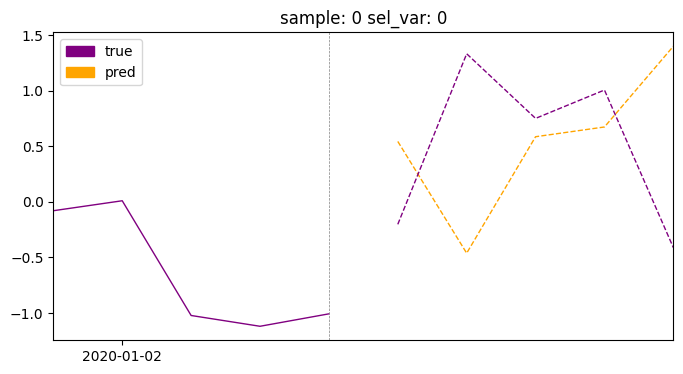

In [4]:
# Test
n_samples = 100
n_vars = 10
lookback = 5
horizon = 5
X_true = np.random.randn(n_samples, n_vars, lookback)
y_true = np.random.randn(n_samples, n_vars, horizon)
y_pred = np.random.randn(n_samples, n_vars, horizon)
# dtms must be a 2D numpy array of datetime objects with the shape 
# (n_samples x (lookback + horizon))
dtms = np.array([pd.date_range('2020-01-01', 
                               periods=lookback + horizon, 
                               freq='D') for i in range(n_samples)])
plot_forecast_2(X_true, y_true, y_pred, dtms=dtms, sel_vars=0, idx=0, 
                figsize=(8, 4), n_samples=1)

In [5]:
#| export

def plot_solar_algorithm_performance(df, var, figsize=(10, 10), ylims_mean=None, 
                                     ylims_std=None):
    # Plot a grid where each row is a solar activity level, and each column
    # is a error type (sfu or percent). Each cell is the result of calling the 
    # function plot_fe.
    # Input:
    # df: dataframe with the results of the forecasting experiment, with the columns
    #     variable, condition, horizon, mean_sfu, std_sfu, mean_percent, std_percent
    # var: variable to plot (F10, S10, M10, Y10)
    # figsize: figure size
    # ylims_mean: List with the y limits of the mean for each error type: 
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # ylims_std: List with the y limits of the standard deviation for each error type:
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # Output:
    # None, but it plots the grid
    sals = ['low', 'moderate', 'elevated', 'high']
    fig, axs = plt.subplots(len(sals), 2, figsize=figsize)
    fig.suptitle(f"Forecast error for {var}")
    for sal_idx, sal in enumerate(sals):
        for idx, err_type in enumerate(['percent', 'sfu']):
            df_var = df[(df['variable'] == var) & (df['condition'] == sal)]
            # Minimum and maximum values across column
            min_val_mean = df[f'mean_{err_type}'].min() if ylims_mean is None else ylims_mean[idx][0]
            max_val_mean = df[f'mean_{err_type}'].max() if ylims_mean is None else ylims_mean[idx][1]
            min_val_std = df[f'std_{err_type}'].min() if ylims_std is None else ylims_std[idx][0]
            max_val_std = df[f'std_{err_type}'].max() if ylims_std is None else ylims_std[idx][1]

            mean_fe = df_var[f'mean_{err_type}'].values
            std_fe = df_var[f'std_{err_type}'].values
            ax = axs[sal_idx, idx]
            ax.plot(mean_fe, color='#000000')
            ax.set_xlabel('Days from Epoch')
            ax.set_ylabel(f'Mean [{err_type}]', color='#000000')
            ax.tick_params(axis='y', labelcolor='#000000')
            ax.set_xticks(range(len(mean_fe)))
            ax.set_xticklabels(range(1, len(mean_fe)+1))
            ax.set_ylim(min_val_mean, max_val_mean)
            ax2 = ax.twinx()
            ax2.plot(std_fe, color='tab:red')
            ax2.set_ylabel(f'STD [{err_type}]', color='tab:red')
            ax2.set_ylim(min_val_std, max_val_std)
            ax2.tick_params(axis='y', labelcolor='tab:red')
            # ax2.set_xticks(range(len(std_fe)))
            # ax2.set_xticklabels(range(1, len(std_fe)+1))
            n_samples = df_var['n_samples'].values[0] 
            ax.set_title(f'{sal}\n{n_samples} forecasts')
            # Draw a grid in the background
            ax.grid(True, which='both', axis='both', color='lightgrey',
                    linestyle='-', linewidth=0.5)
            fig.tight_layout()

/tmp/ipykernel_12250/871416671.py:53: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


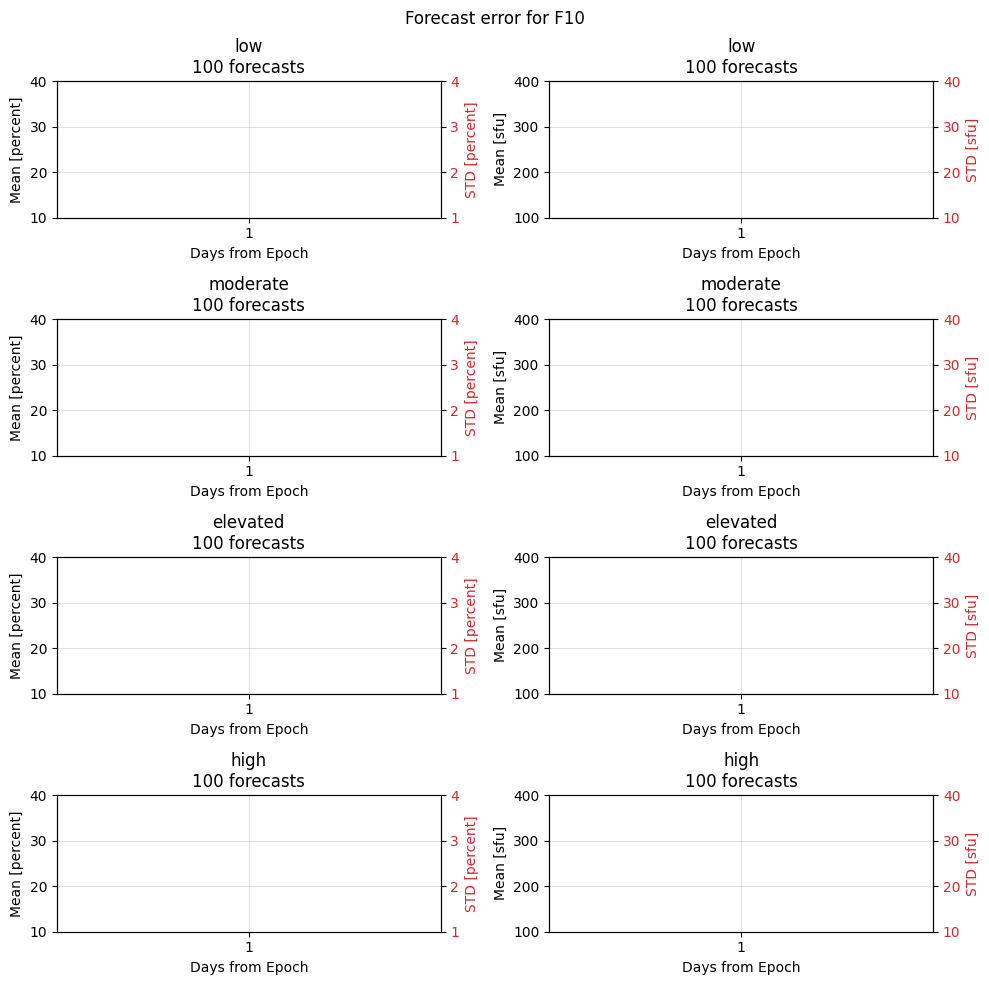

In [6]:
# Test 
df = pd.DataFrame({'variable': ['F10', 'F10', 'F10', 'F10', 'S10', 'S10', 'S10', 'S10'],
                   'condition': ['low', 'moderate', 'elevated', 'high', 'low', 'moderate', 'elevated', 'high'],
                   'horizon': [1, 1, 1, 1, 1, 1, 1, 1],
                   'n_samples': [100, 100, 100, 100, 100, 100, 100, 100],
                   'mean_percent': [10, 20, 30, 40, 10, 20, 30, 40],
                   'std_percent': [1, 2, 3, 4, 1, 2, 3, 4],
                   'mean_sfu': [100, 200, 300, 400, 100, 200, 300, 400],
                   'std_sfu': [10, 20, 30, 40, 10, 20, 30, 40]})
plot_solar_algorithm_performance(df, 'F10', figsize=(10, 10))

In [7]:
#|export
def bold_best(X, X_ref, higher_better=False, bold_ref_too=False, 
              bold_equal=False, use_abs=False):
    """
        Returns X with the best values in bold, with respect to X_ref, position by
        position, i.e., if X[0] is better than X_ref[0] it will be bolded. 
        Input:
            X: 1D numpy array
            X_ref: 1D numpy array
            higher_better: If True, then the best values are the highest ones
            bold_ref_too: If True, best values in X_ref are also in bold.
            bold_equal: If bold_equal is True, then the values equal to the 
            best ones are also bolded
            use_abs: If True, then the absolute values are used to compare
        Output:
            X: 1D numpy array with the best values in bold (or a tuple of two
            1D numpy arrays if bold_ref_too is True)
    """
    if use_abs:
        X_abs = np.abs(X)
        X_ref_abs = np.abs(X_ref)
    else:
        X_abs = X
        X_ref_abs = X_ref
    if higher_better:
        if bold_equal:
            best = np.greater_equal(X_abs, X_ref_abs)
        else:
            best = np.greater(X_abs, X_ref_abs)
    else:
        if bold_equal:
            best = np.less_equal(X_abs, X_ref_abs)
        else:
            best = np.less(X_abs, X_ref_abs)
    # Make bold
    X = np.array([f'\\textbf{{{x}}}' if best[i] else f'{x}' for i, x in enumerate(X_abs)])
    if bold_ref_too:
        X_ref = np.array([f'\\textbf{{{x}}}' if not best[i] else f'{x}' for i, x in enumerate(X_ref_abs)])
        return X, X_ref
    else:
        return X

In [8]:
# Test
X = np.array([1, 2, 3, 4, 5])
X_ref = np.array([5, 4, 3, 2, 1])

res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False)
test_eq(res, (np.array(['1', '2', '3', '\\textbf{4}', '\\textbf{5}'])))

res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False, bold_equal=True)
test_eq(res, (np.array(['1', '2', '\\textbf{3}', '\\textbf{4}', '\\textbf{5}'])))

res = bold_best(X, X_ref, higher_better=False, bold_ref_too=False)
test_eq(res, (np.array(['\\textbf{1}', '\\textbf{2}', '3', '4', '5'])))

# TODO: Bold 3? 
res = bold_best(X, X_ref, higher_better=True, bold_ref_too=True)
test_eq(res, (np.array(['1', '2', '3', '\\textbf{4}', '\\textbf{5}']),
                np.array(['\\textbf{5}', '\\textbf{4}', '\\textbf{3}', '2', '1'])))

# Test use_abs
X = np.array([-1, 2, 3, 4, 5])
X_ref = np.array([-5, 4, 3, 2, 1])

res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False, use_abs=True)
test_eq(res, (np.array(['1', '2', '3', '\\textbf{4}', '\\textbf{5}'])))
res = bold_best(X, X_ref, higher_better=True, bold_ref_too=False, use_abs=False)
test_eq(res, (np.array(['\\textbf{-1}', '2', '3', '\\textbf{4}', '\\textbf{5}'])))



In [9]:
#|export
def convert_uuids_to_indices():
    cuda_visible_devices = os.environ.get("CUDA_VISIBLE_DEVICES", "")
    uuids = re.findall(r"\b[0-9a-fA-F]{8}(?:-[0-9a-fA-F]{4}){3}-[0-9a-fA-F]{12}\b", cuda_visible_devices)

    if uuids:
        indices = [str(i) for i in range(len(uuids))]
        os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(indices)

In [10]:
#|eval: false
#|hide
from nbdev import *
nbdev_export()